# Reflection

> **What you'll learn:** How to build a **Reflection Agent** that iteratively critiques and refines its own outputs — using LangChain for structured prompting and LangGraph for workflow orchestration.

A **Reflection Agent** is an AI system that goes beyond just generating answers — it actively critiques its own outputs and keeps refining them. You can think of it as a loop between two roles:

- **Generator:** Drafts the initial response.
- **Reflector:** Reviews that draft, points out flaws or gaps, and suggests improvements.

This back-and-forth runs for a few iterations, and with each cycle, the output gets more polished, reliable, and useful. The AI essentially learns from its own mistakes in real time, much like a writer rewriting their draft after a round of editorial feedback.

![Reflection](attachment:fc393f72-3401-4b86-b0d3-e4789b640a27.png)

In this notebook, we'll build a Reflection Agent for a **LinkedIn post generator** using **LangGraph**, a framework designed for creating self-improving AI systems. The workflow mimics human-like reflective thinking — the agent doesn't stop at the first draft, but keeps refining until the content feels polished and engaging.


### Setting up the Environment

We use LangChain and LangGraph to build the reflection workflow. Libraries are imported step by step as needed to keep the learning flow clean.

Set up your environment variables for API integrations in a `.env` file:
```
ANTHROPIC_API_KEY="your-anthropic-api-key"
# LANGCHAIN_API_KEY="your-langchain-api-key"  # optional
# LANGCHAIN_TRACING_V2=True                   # optional
# LANGCHAIN_PROJECT="multi-agent-swarm"       # optional
```

In [ ]:
# # ─────────────────────────────────────────────
# # Purpose : Load environment variables and initialize the LLM
# # Input   : .env file with ANTHROPIC_API_KEY
# # Output  : `llm` — configured Anthropic Claude instance
# # ─────────────────────────────────────────────

# from langchain_anthropic import ChatAnthropic
# from dotenv import load_dotenv

# load_dotenv()
# load_dotenv(dotenv_path="../.env", override=True)

# llm = ChatAnthropic(model="claude-3-7-sonnet-latest", temperature=0)

In [2]:
# ─────────────────────────────────────────────
# Purpose : Import LLM helpers and initialize the language model
# Input   : helpers/utils.py factory functions
# Output  : `llm` — configured LLM instance
# ─────────────────────────────────────────────

import os
import sys

sys.path.append(os.path.abspath("../.."))
from helpers.utils import get_groq_llm, get_databricks_llm

print("LLM helpers imported successfully!")

# --- Select LLM based on platform ---
if sys.platform == "win32":
    llm = get_groq_llm("openai/gpt-oss-120b")
elif sys.platform == "darwin":
    llm = get_databricks_llm("databricks-claude-opus-4-6")
else:
    print("linux")

# --- Confirm initialization ---
if hasattr(llm, 'model_name'):
    print(f"LLM initialized: {llm.model_name}")
elif hasattr(llm, 'model'):
    print(f"LLM initialized: {llm.model} (Databricks)")
else:
    print("LLM initialized: Groq LLM")

LLM helpers imported successfully!
LLM initialized: databricks-claude-opus-4-6 (Databricks)


### Generator

Now that we have our LLM configured, we create the first agent component: a **LinkedIn post generator**. This agent will draft posts that can later be refined through self-review. Let's start by defining the generation prompt.

In [3]:
# ─────────────────────────────────────────────
# Purpose : Define the LinkedIn post generator prompt template
# Input   : User request via MessagesPlaceholder
# Output  : `post_creation_prompt` — ChatPromptTemplate for post generation
# ─────────────────────────────────────────────

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

post_creation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert LinkedIn content creator tasked with crafting compelling, professional, and high-performing LinkedIn posts. "
            "Create the most effective LinkedIn post possible based on the user's requirements. "
            "If the user provides feedback or suggestions, respond with an improved version that incorporates their input while enhancing overall quality and engagement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


We use `ChatPromptTemplate` to structure the prompt with two main parts:

- **System Message:** Defines the assistant's role as a professional LinkedIn content strategist, responsible for generating and revising high-quality posts.
- **`MessagesPlaceholder`:** A dynamic slot for user input, populated at runtime with the request.

Next, we integrate the prompt with our LLM using the **pipe operator** (`|`) to create a processing chain. This passes the output from `post_creation_prompt` directly into the LLM as input.

In [4]:
# ─────────────────────────────────────────────
# Purpose : Create the generator chain and produce an initial LinkedIn post
# Input   : post_creation_prompt, llm, post_request
# Output  : `generated_post` — the first-draft LinkedIn post text
# ─────────────────────────────────────────────

linkedin_post_generator = post_creation_prompt | llm

generated_post = ""
post_request = HumanMessage(
    content="Create a LinkedIn post on AI tools for developers under 200 words."
)

print("=== INITIAL LINKEDIN POST ===")
for chunk in linkedin_post_generator.stream({"messages": [post_request]}):
    print(chunk.content, end="")
    generated_post += chunk.content

print("\n" + "="*60 + "\n")

=== INITIAL LINKEDIN POST ===
# Here's a LinkedIn post for you:

---

**🚀 AI Tools Every Developer Should Be Using in 2025**

The developers who embrace AI aren't being replaced.

They're becoming 10x more productive.

Here are 5 AI tools transforming how we write code:

**1. GitHub Copilot** → Your AI pair programmer
**2. Cursor** → AI-first code editor that understands your entire codebase
**3. ChatGPT / Claude** → Debug faster, brainstorm architectures, write docs
**4. Tabnine** → Privacy-focused code completion
**5. Amazon CodeWhisperer** → Optimized for AWS workflows

But here's what most developers get wrong:

They use AI to *write* code.
The real power is using AI to *think* about code.

↳ Challenge your design decisions
↳ Explore edge cases you'd miss
↳ Review your logic before it hits production

The best developers I know treat AI as a **thought partner**, not a shortcut.

AI won't replace developers.
But developers using AI will replace those who don't.

Which AI tool has ch

We've created our content generator, but it operates in isolation. The next step is to add the **reflection capability** that will evaluate and improve our content.

### Reflect

With the generator ready, we now create a **critic agent** — essentially a social media strategist. This agent analyzes the generated post from multiple perspectives: engagement potential, brand alignment, tone, and overall optimization.

In [5]:
# ─────────────────────────────────────────────
# Purpose : Define the social media strategist critique prompt
# Input   : Generated LinkedIn post via MessagesPlaceholder
# Output  : `social_media_critic` — chain that produces actionable feedback
# ─────────────────────────────────────────────

social_media_critique_prompt = ChatPromptTemplate.from_messages([
    (
        "system", 
        """You are a LinkedIn content strategist and thought leadership expert. Analyze the given LinkedIn post and provide a comprehensive critique focusing on:

        **Content Quality & Professionalism:**
        - Overall quality, tone clarity, and LinkedIn best practices alignment
        - Structure, readability, and professional credibility building
        - Industry relevance and audience targeting
        
        **Engagement & Algorithm Optimization:**
        - Hook effectiveness and storytelling quality
        - Engagement potential (likes, comments, shares)
        - LinkedIn algorithm optimization factors
        - Word count and formatting effectiveness
        
        **Technical Elements:**
        - Hashtag relevance, reach, and strategic placement
        - Call-to-action strength and clarity
        - Use of formatting (line breaks, bullet points, mentions)
        
        Provide specific, actionable feedback that includes:
        - Key strengths and improvement areas
        - Concrete suggestions for enhancing engagement and professionalism
        - Practical recommendations for the next revision

        Keep your critique constructive and focused on measurable improvements, prioritizing actionable insights that will guide the post's revision and lead to tangible content enhancements."""
    ),
    MessagesPlaceholder(variable_name="messages")
])

social_media_critic = social_media_critique_prompt | llm

Now, let's see how the critic evaluates our generated post:

In [7]:
# ─────────────────────────────────────────────
# Purpose : Run the critic agent on the generated post
# Input   : post_request, generated_post
# Output  : `feedback_result` — strategist's critique text
# ─────────────────────────────────────────────

print("=== SOCIAL MEDIA STRATEGIST FEEDBACK ===")
feedback_result = ""
for chunk in social_media_critic.stream({"messages": [post_request, HumanMessage(content=generated_post)]}):
    print(chunk.content, end="")
    feedback_result += chunk.content

print("\n" + "="*60 + "\n")

=== SOCIAL MEDIA STRATEGIST FEEDBACK ===
# LinkedIn Post Critique: AI Tools for Developers

## Overall Assessment
This is a **strong, well-structured post** that hits many LinkedIn best practices. It's concise, scannable, and delivers genuine value. Let me break down what works, what could improve, and specific next steps.

---

## Key Strengths

**Hook & Opening (9/10)**
The opening line *"The developers who embrace AI aren't being replaced"* directly addresses a fear every developer has. It creates instant tension and earns the scroll-stop. The follow-up "10x more productive" adds aspirational pull.

**Structure & Readability (9/10)**
The numbered list, arrow formatting, and short line breaks make this extremely scannable. You've nailed the LinkedIn mobile reading experience, where most users consume content. The post flows naturally from list → insight → reframe → CTA.

**The "Insight Pivot" (10/10)**
This section is the post's strongest asset:
> *"They use AI to write code. The rea

The feedback from our strategist provides specific, actionable insights. This is where the **reflection pattern** becomes powerful — we're not just generating content, we're systematically evaluating and identifying improvement opportunities.

### Repeat

Now that we have both a generator and a critic, let's implement the basic **reflection loop**. The pattern involves feeding the critique back to the generator for improvement:

In [8]:
# ─────────────────────────────────────────────
# Purpose : Feed critic feedback back to the generator for one manual revision
# Input   : post_request, generated_post, feedback_result
# Output  : Refined LinkedIn post (printed)
# ─────────────────────────────────────────────

print("=== REFINED LINKEDIN POST ===")
for chunk in linkedin_post_generator.stream(
    {"messages": [post_request, AIMessage(content=generated_post), HumanMessage(content=feedback_result)]}
):
    print(chunk.content, end="")

print("\n" + "="*60 + "\n")

=== REFINED LINKEDIN POST ===


That's an incredibly thorough and actionable critique. Here's the revised post incorporating every piece of feedback:

---

⚡ **5 AI Tools Every Developer Should Know in 2025**

The developers who embrace AI aren't being replaced.

They're becoming 10x more productive.

Here are 5 tools transforming how we write code:

**1. GitHub Copilot** → Your AI pair programmer
**2. Cursor** → AI-first editor that understands your entire codebase
**3. ChatGPT / Claude** → Debug faster, brainstorm architectures, write docs
**4. Tabnine** → Privacy-focused code completion
**5. Amazon Q Developer** → Optimized for AWS workflows

I started using Cursor three months ago and cut my PR review time by 40%. That's when I realized something:

Most developers use AI to *write* code.
The real power is using AI to *think* about code.

↳ Challenge your design decisions
↳ Explore edge cases you'd miss
↳ Review your logic before it hits production

The best developers treat AI as a

The sequence of messages ensures context is preserved while allowing the generator to incorporate feedback iteratively.

However, while this manual approach works for simple content tasks, it quickly becomes cumbersome for more complex workflows. That's where **LangGraph** comes in — providing a structured framework for orchestrating multiple agents efficiently.

### Workflow Orchestration with LangGraph

LangGraph allows us to build sophisticated agent workflows with:

- **State management** to track context across multiple steps
- **Conditional logic** to decide whether to continue or terminate the loop
- **Automatic orchestration** for seamless communication between agents

We define a `ContentState` to track our workflow. Using the `Annotated` type with `add_messages`, we ensure that messages accumulate correctly throughout the process.

In [9]:
# ─────────────────────────────────────────────
# Purpose : Build the LangGraph reflection workflow with state, nodes, and edges
# Input   : linkedin_post_generator, social_media_critic chains
# Output  : `linkedin_workflow` — compiled LangGraph state machine
# ─────────────────────────────────────────────

from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from typing_extensions import TypedDict

# --- State schema ---
class ContentState(TypedDict):
    messages: Annotated[list, add_messages]

# --- Graph nodes ---
async def post_creation_node(state: ContentState) -> ContentState:
    """Generate or improve LinkedIn post based on current state."""
    return {"messages": [await linkedin_post_generator.ainvoke(state["messages"])]}

async def social_critique_node(state: ContentState) -> ContentState:
    """Provide social media strategy feedback for the LinkedIn post."""
    message_role_map = {"ai": HumanMessage, "human": AIMessage}

    # Swap roles so the critic sees the AI output as a "user" message
    transformed_messages = [state["messages"][0]] + [
        message_role_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]

    strategy_feedback = await social_media_critic.ainvoke(transformed_messages)
    return {"messages": [HumanMessage(content=strategy_feedback.content)]}

# --- Loop control ---
def should_continue_refining(state: ContentState):
    """End after 3 complete creation-feedback cycles (> 6 messages)."""
    if len(state["messages"]) > 6:
        return END
    return "social_critique"

# --- Assemble graph ---
content_workflow_builder = StateGraph(ContentState)
content_workflow_builder.add_node("create_post", post_creation_node)
content_workflow_builder.add_node("social_critique", social_critique_node)

content_workflow_builder.add_edge(START, "create_post")
content_workflow_builder.add_conditional_edges("create_post", should_continue_refining)
content_workflow_builder.add_edge("social_critique", "create_post")

content_memory = InMemorySaver()
linkedin_workflow = content_workflow_builder.compile(checkpointer=content_memory)


Visualize the compiled reflection workflow graph to see how the generator and critic nodes are connected in the iterative loop.

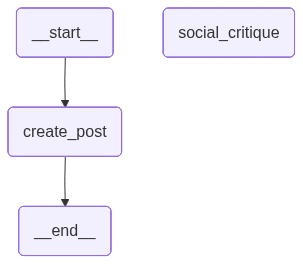

In [12]:
from IPython.display import Image, display

display(Image(linkedin_workflow.get_graph().draw_mermaid_png()))

### Testing

Run the complete reflection workflow end-to-end. The agent will cycle through generation and critique until the message count exceeds the threshold (3 full cycles).

In [13]:
# ─────────────────────────────────────────────
# Purpose : Stream the reflection workflow and display each step
# Input   : content_brief (HumanMessage), session_config
# Output  : Step-by-step workflow events (printed)
# ─────────────────────────────────────────────

session_config = {"configurable": {"thread_id": "user1"}}

content_brief = HumanMessage(
    content="Create a LinkedIn post on AI tools for developers under 180 words."
)

print("=== RUNNING AUTOMATED LINKEDIN CONTENT WORKFLOW ===\n")

async for workflow_event in linkedin_workflow.astream(
    {"messages": [content_brief]},
    session_config,
):
    print("Workflow Step:", workflow_event)
    print("-" * 50)

=== RUNNING AUTOMATED LINKEDIN CONTENT WORKFLOW ===

Workflow Step: {'create_post': {'messages': [AIMessage(content="# Here's your LinkedIn post:\n\n---\n\n**🚀 AI Tools Every Developer Should Be Using in 2025**\n\nThe developers who embrace AI aren't being replaced.\nThey're becoming 10x more productive.\n\nHere are 5 AI tools transforming how we code:\n\n**⚡ GitHub Copilot** → Your AI pair programmer\n**⚡ Cursor** → AI-native code editor that thinks with you\n**⚡ ChatGPT / Claude** → Debug, refactor, and brainstorm instantly\n**⚡ Tabnine** → Privacy-first code completion\n**⚡ Amazon CodeWhisperer** → Optimized for AWS workflows\n\nBut here's what most developers get wrong:\n\nThey use AI to write code.\nTop developers use AI to **think better**.\n\n↳ Architecture decisions\n↳ Code reviews\n↳ Documentation\n↳ Test generation\n↳ Learning new frameworks faster\n\nThe gap between developers who leverage AI and those who don't is widening **every single month.**\n\nThe best time to start w

In [14]:
# ─────────────────────────────────────────────
# Purpose : Inspect the final workflow state after all cycles complete
# Input   : session_config
# Output  : Total message count in conversation
# ─────────────────────────────────────────────

final_state = linkedin_workflow.get_state(session_config)
print("\n=== FINAL CONTENT WORKFLOW STATE ===")
print("Total messages in conversation:", len(final_state.values["messages"]))


=== FINAL CONTENT WORKFLOW STATE ===
Total messages in conversation: 8


In [15]:
# ─────────────────────────────────────────────
# Purpose : Pretty-print the full conversation flow across all cycles
# Input   : final_state
# Output  : Formatted message history
# ─────────────────────────────────────────────

ChatPromptTemplate.from_messages(final_state.values["messages"]).pretty_print()

================================ Human Message =================================

Create a LinkedIn post on AI tools for developers under 180 words.

================================== Ai Message ==================================

# Here's your LinkedIn post:

---

**🚀 AI Tools Every Developer Should Be Using in 2025**

The developers who embrace AI aren't being replaced.
They're becoming 10x more productive.

Here are 5 AI tools transforming how we code:

**⚡ GitHub Copilot** → Your AI pair programmer
**⚡ Cursor** → AI-native code editor that thinks with you
**⚡ ChatGPT / Claude** → Debug, refactor, and brainstorm instantly
**⚡ Tabnine** → Privacy-first code completion
**⚡ Amazon CodeWhisperer** → Optimized for AWS workflows

But here's what most developers get wrong:

They use AI to write code.
Top developers use AI to **think better**.

↳ Architecture decisions
↳ Code reviews
↳ Documentation
↳ Test generation
↳ Learning new frameworks faster

The gap between developers who leverage

### Key Takeaway

Self-reflection is inherently cyclic and is much more effective when the reflection step has **additional context or feedback** (from tool observations, checks, etc.). When the reflection step simply prompts the LLM to reflect on its own output — as in this notebook — it can still improve quality (since the LLM gets multiple "shots" at a good output), but the gains are less guaranteed.

For stronger results, consider combining reflection with:
- **External tool calls** (web search, code execution) for grounding
- **Structured evaluation criteria** for more targeted feedback
- **Reflexion** (see the companion notebook) for research-backed iterative improvement

In [ ]:
# ─────────────────────────────────────────────
# Purpose : Provide alternative topics for experimentation
# Input   : None
# Output  : `alternative_topics` — list of prompt strings to try
# ─────────────────────────────────────────────

alternative_topics = [
    "Write a LinkedIn post about remote work productivity tips under 150 words.",
    "Create a LinkedIn post on AI tools for developers under 180 words.",
    "Write a LinkedIn post about career pivoting in tech under 200 words.",
    "Create a LinkedIn post on work-life balance for software engineers under 160 words.",
]